In [1]:
# pip install networkx==2.8.8
# pip install matplotlib == 3.2.2

In [2]:
import networkx as nx
import dgl
import pandas as pd
import numpy as np

c:\Users\user\anaconda3\envs\dasktop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* session: 1~13
* round數量不一定

In [3]:
feature_df = pd.read_csv('data/graph_feature.csv')
structure_df = pd.read_csv('data/graph_structure.csv')

In [4]:
feature_df

,session,uid,round,color,score,num_of_neighbor,hist_color,hist_neighbor,hist_skip,action
0,1,1,1,4,0,6,0.0,0.0,0.0,0
1,1,2,1,4,0,6,0.0,0.0,0.0,0
2,1,3,1,4,0,6,0.0,0.0,0.0,0
3,1,4,1,4,0,6,0.0,0.0,0.0,0
4,1,5,1,4,0,6,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2148,13,16,6,2,100,7,0.2,0.0,0.8,1
2149,13,17,6,3,100,7,0.2,0.2,0.6,1
2150,13,18,6,1,89,9,0.4,0.0,0.6,2
2151,13,19,6,4,100,7,0.0,0.6,0.4,1


In [5]:
structure_df

,session,uid,round,linked
0,1,1,1,"2,3,4,13,14,15"
1,1,2,1,"1,3,4,5,14,15"
2,1,3,1,"1,2,4,5,6,15"
3,1,4,1,"1,2,3,5,6,7"
4,1,5,1,"2,3,4,6,7,8"
...,...,...,...,...
2148,13,16,6,"13, 14, 15, 17, 18, 8, 19"
2149,13,17,6,"14, 15, 16, 18, 19, 4, 6"
2150,13,18,6,"1, 15, 16, 17, 19, 20, 7, 5, 11"
2151,13,19,6,"2, 17, 18, 4, 16, 5, 6"


用structure建立graph

In [6]:
# def show_graph(nx_g):
#     plt.figure(figsize=[5,5])
#     # nx.draw(nx_g, with_labels=True)
#     # plt.show()
#     labels = {}
#     for i in range(1, len(nx_g.nodes())+1):
#         labels[i] = i
#     pos = nx.circular_layout(nx_g)  # 環狀布圖
#     nx.draw_networkx_nodes(nx_g, pos, node_color='tab:blue')
#     nx.draw_networkx_labels(nx_g, pos, labels, font_size=10, font_color='black')
#     nx.draw_networkx_edges(nx_g, pos, alpha=0.5, width=1)

In [7]:
def create_graph(session, df):  # df size = graph size
    size = len(df)+1
    G = nx.Graph()
    nodes = range(1, size)
    G.add_nodes_from(nodes)
    edge_list = []
    for uid in range(1, size):
        neighbor_list = df[df['uid'] == uid].iloc[0]['linked'].split(',')
        edge_list = [(int(uid), int(neighbor)) for neighbor in neighbor_list]
        G.add_edges_from(edge_list)
    return G

def add_feature(graph, f_df):
    feature_col_list = ['color', 'score', 'num_of_neighbor', 'hist_color', 'hist_neighbor', 'hist_skip']
    for n in graph.nodes():
        for f in feature_col_list:
            graph.nodes[n][f] = f_df[f_df['uid']==n][f].tolist()[0]    # 取出uid符合的user的f欄位，從series型態轉成list再取值
    return graph

# def get_training_data(session, round):
#     test_df = structure_df[structure_df['session'] == session]
#     test_df = test_df[test_df['round'] == round]

#     graph = create_graph(1, test_df)
#     show_graph(graph)
#     return graph

In [8]:
graph_list = []
label_list = []
for session in range(1, 14):
    s_all_df = structure_df[structure_df['session'] == session]
    for round in s_all_df['round'].unique():
        
        s_df = s_all_df[s_all_df['round'] == round]
        f_df = feature_df.iloc[s_df.index]
        
        graph = create_graph(session, s_df)
        graph = add_feature(graph, f_df)
        graph_list.append(graph)

        labels = f_df['action'].tolist()
        label_list.append(labels)
len(graph_list)

106

---

In [9]:
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.nn import functional as F

In [10]:
class graphDataset(Dataset):
    def __init__(self, graph_list, label_list):
        feature_matrix_list = []
        for g in graph_list:
            feature_matrix = [list(g.nodes[j].values()) for j in range(1, g.number_of_nodes()+1)]
            feature_matrix_list.append(torch.tensor(feature_matrix, dtype=torch.float))
        
        self.feature_matrix = feature_matrix_list
        
        adj_matrix_list = []
        for g in graph_list:
            adj_matrix = nx.adjacency_matrix(g).todense()
            adj_matrix_list.append(torch.tensor(adj_matrix, dtype=torch.float))
        self.adj_matrix = adj_matrix_list

        labels = []
        for i in range(len(label_list)):
            labels.append(torch.tensor(label_list[i], dtype=torch.int64))
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.feature_matrix[idx]
        adj_matrix = self.adj_matrix[idx]
        labels = self.labels[idx]

        return features, adj_matrix, labels

In [11]:
class GraphConvolutionalLayer(nn.modules.Module):
    def __init__(self, in_feature, out_feature, bias=True):
        super(GraphConvolutionalLayer, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = Parameter(torch.FloatTensor(in_feature, out_feature))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_feature))
        else:
            self.bias = None
    def forward(self, adj_matrix, features):
        output = torch.mm(adj_matrix, features)
        output = torch.mm(output, self.weight)
        if(self.bias is not None):
            return output + self.bias
        else:
            return output
    

class GCN_Model(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super(GCN_Model, self).__init__()
        self.gcn = GraphConvolutionalLayer(in_dim, hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout
    def forward(self, feature, adj_matrix):
        x = torch.nn.functional.relu(self.gcn(adj_matrix, feature))
        x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        
        x = self.linear(x)
        output = torch.nn.functional.softmax(x, dim=1)
        return output

In [12]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double().sum()
    return correct / len(labels)

In [13]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epoch, eval=True):
    t = time.time()
    loss_hist = []
    for i in range(epoch):
        model.train()
        for features, adj_matrix, labels in iter(train_dataloader):
            features = features.squeeze()
            adj_matrix = adj_matrix.squeeze()
            labels = labels
            
            output = model(features, adj_matrix)
            loss = loss_fn(output, labels)
            loss_hist.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if(eval and i%5==0):
            model.eval()
            total_loss = 0
            for features, adj_matrix, labels in iter(test_dataloader):
                output = model(features, adj_matrix)
                total_loss += float(loss_fn(output, labels))
            print('eval avg loss: ', total_loss/len(test_dataloader))
            print('acc: ', float(accuracy(output, labels)))
            print('='*80)
    return loss_hist

In [14]:
train_dataloader = graphDataset(graph_list[:90], label_list[:90])
test_dataloader = graphDataset(graph_list[90:], label_list[90:])

C:\Users\user\AppData\Local\Temp\ipykernel_7124\2866558056.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(g).todense()


In [15]:
model = GCN_Model(6, 6, 3, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

l = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epoch=20)

eval avg loss:  1.0965762324631214
acc:  0.15
eval avg loss:  1.0389861688017845
acc:  0.6
eval avg loss:  1.0004987344145775
acc:  0.6
eval avg loss:  0.977744422852993
acc:  0.6


In [22]:
import matplotlib.pyplot as plt


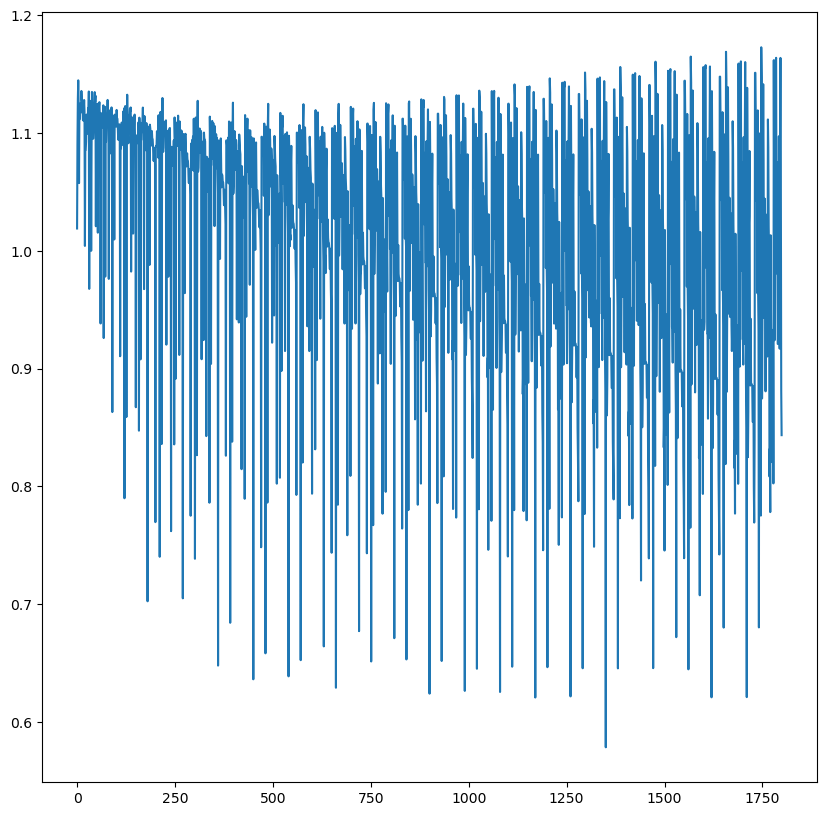

In [26]:
plt.figure(figsize=((10, 10)))
plt.plot([i for i in range(len(l))], l)
plt.show()
display()